# College Football Playoff Predictor

The goal of this project create a models to predict post-season results for each FBS team for a given year. The models will be be trained to understand the committee's selection process and predict which teams will be selected for the College Football Playoff (CFP). Data from Sports Reference will be used to train the models, including basic resume information such as win-loss records, strength of schedule, and conference results. 


## Import Libraries

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Load and Prepare Data

Sports Reference was used as the primary source for its Win-Loss records over each year. They offer CSV table formats for each year. 'Ranked' and 'Power_Conf' classification variables were engineered as well.

**Data Source:** [Sports Reference](https://www.sports-reference.com/cfb/)


In [31]:
# Define power conferences by era
power_5 = ['Big Ten', 'Big 12', 'SEC', 'ACC', 'Pac-12']
power_4 = ['Big Ten', 'Big 12', 'SEC', 'ACC']

dfs = []

# Load data for each season
for yr in range(2014, 2025 + 1):
    standings_raw = pd.read_csv(f"sports-reference-data/sr-standings-{yr}.csv")

    year_df = pd.DataFrame({
        'Year': yr,
        'Team': standings_raw['School'],
        'Conference': standings_raw['Conf'],
        'Wins': standings_raw['W'],
        'Losses': standings_raw['L'],
        'SoS': standings_raw['SOS'],  # Strength of Schedule
    })

    # Clean conference names (remove division info in parentheses)
    year_df['Conference'] = year_df['Conference'].str.replace(r'\s*\(.*\)', '', regex=True)
    
    # Calculate total games played
    year_df['Games'] = year_df['Wins'] + year_df['Losses']
    
    # Mark power conference teams (Pac-12 only exists before 2024)
    year_df['Power_Conf'] = year_df['Conference'].isin(
        power_5 if yr < 2024 else power_4
    ).astype(int)
    
    # Find ranking column (column name varies by year)
    possible_rank_cols = ['AP Rank', 'AP Curr']
    rank_series = next(
        (standings_raw[c] for c in possible_rank_cols if c in standings_raw.columns),
        None
    )

    # Binary: was team ranked at end of season?
    year_df['Ranked'] = rank_series.notna().astype(int) if rank_series is not None else 0

    dfs.append(year_df)

# Combine all years into single dataframe
df = pd.concat(dfs, ignore_index=True)

# Calculate win percentage
df['Win_Pct'] = df['Wins'] / df['Games']

# Clean Outliers in SoS
df = df[df['SoS'] >= -15]

df.head()

,Year,Team,Conference,Wins,Losses,SoS,Games,Power_Conf,Ranked,Win_Pct
0,2014,Florida State,ACC,13,1,5.13,14,1,1,0.928571
1,2014,Clemson,ACC,10,3,2.86,13,1,1,0.769231
2,2014,Louisville,ACC,9,4,3.22,13,1,1,0.692308
3,2014,Boston College,ACC,7,6,2.35,13,1,0,0.538462
4,2014,North Carolina State,ACC,8,5,1.25,13,1,0,0.615385


## Create Target Variables

These playoffs, starting in 2014, have evolved recently to inlude 12 teams rather than 4. However, the 'New Years Six' Bowls in a way represented the 12 highest ranked teams. So, New Years Six qualification data from 2014-2023 was collected to train the model to predict 2024-2025 12-team playoff qualification

In [32]:
# Initialize target variables
df['Conf_Champ'] = 0
df['Conf_Finalist'] = 0
df['Final_4'] = 0
df['Final_12'] = 0
df['National_Champ'] = 0

df.head()

,Year,Team,Conference,Wins,Losses,SoS,Games,Power_Conf,Ranked,Win_Pct,Conf_Champ,Conf_Finalist,Final_4,Final_12,National_Champ
0,2014,Florida State,ACC,13,1,5.13,14,1,1,0.928571,0,0,0,0,0
1,2014,Clemson,ACC,10,3,2.86,13,1,1,0.769231,0,0,0,0,0
2,2014,Louisville,ACC,9,4,3.22,13,1,1,0.692308,0,0,0,0,0
3,2014,Boston College,ACC,7,6,2.35,13,1,0,0.538462,0,0,0,0,0
4,2014,North Carolina State,ACC,8,5,1.25,13,1,0,0.615385,0,0,0,0,0


In [33]:
# Define playoff results for all years
playoff_results = {
    2014: {'Ohio State': 'Champion', 'Oregon': 'Final', 'Alabama': 'Semifinal', 'Florida State': 'Semifinal'},
    2015: {'Alabama': 'Champion', 'Clemson': 'Final', 'Oklahoma': 'Semifinal', 'Michigan State': 'Semifinal'},
    2016: {'Clemson': 'Champion', 'Alabama': 'Final', 'Ohio State': 'Semifinal', 'Washington': 'Semifinal'},
    2017: {'Alabama': 'Champion', 'Georgia': 'Final', 'Oklahoma': 'Semifinal', 'Clemson': 'Semifinal'},
    2018: {'Clemson': 'Champion', 'Alabama': 'Final', 'Notre Dame': 'Semifinal', 'Oklahoma': 'Semifinal'},
    2019: {'LSU': 'Champion', 'Clemson': 'Final', 'Ohio State': 'Semifinal', 'Oklahoma': 'Semifinal'},
    2020: {'Alabama': 'Champion', 'Ohio State': 'Final', 'Clemson': 'Semifinal', 'Notre Dame': 'Semifinal'},
    2021: {'Georgia': 'Champion', 'Alabama': 'Final', 'Michigan': 'Semifinal', 'Cincinnati': 'Semifinal'},
    2022: {'Georgia': 'Champion', 'TCU': 'Final', 'Michigan': 'Semifinal', 'Ohio State': 'Semifinal'},
    2023: {'Michigan': 'Champion', 'Washington': 'Final', 'Alabama': 'Semifinal', 'Texas': 'Semifinal'},
    
    # 12-team playoff (2024 - first year of new format)
    2024: {
        'Ohio State': 'Champion', 'Notre Dame': 'Final',
        'Penn State': 'Semifinal', 'Texas': 'Semifinal',
        'Georgia': 'Quarterfinal', 'Oregon': 'Quarterfinal', 
        'Boise State': 'Quarterfinal', 'Arizona State': 'Quarterfinal',
        'Tennessee': 'First Round', 'Indiana': 'First Round', 
        'SMU': 'First Round', 'Clemson': 'First Round'
    },
    
    # 12-team playoff (2025)
    2025: {
        'Ohio State': 'Champion', 'Notre Dame': 'Final',
        'Texas': 'Semifinal', 'Penn State': 'Semifinal',
        'Georgia': 'Quarterfinal', 'Oregon': 'Quarterfinal', 
        'Boise State': 'Quarterfinal', 'Arizona State': 'Quarterfinal',
        'Tennessee': 'First Round', 'Indiana': 'First Round', 
        'SMU': 'First Round', 'Clemson': 'First Round'
    }
}

# NY6 bowl participants (2014-2023) - these count as Final_12
ny6_bowls = {
    2014: ['Boise State', 'Arizona', 'TCU', 'Ole Miss', 'Georgia Tech', 'Mississippi State',
           'Michigan State', 'Baylor', 'Oregon', 'Florida State', 'Ohio State', 'Alabama'],
    2015: ['Houston', 'Florida State', 'Clemson', 'Oklahoma', 'Alabama', 'Michigan State',
           'Ohio State', 'Notre Dame', 'Stanford', 'Iowa', 'Ole Miss', 'Oklahoma State'],
    2016: ['Florida State', 'Michigan', 'Alabama', 'Washington', 'Clemson', 'Ohio State',
           'Wisconsin', 'Western Michigan', 'USC', 'Penn State', 'Oklahoma', 'Auburn'],
    2017: ['Ohio State', 'USC', 'Penn State', 'Washington', 'Wisconsin', 'Miami',
           'UCF', 'Auburn', 'Georgia', 'Oklahoma', 'Alabama', 'Clemson'],
    2018: ['Florida', 'Michigan', 'Clemson', 'Notre Dame', 'Alabama', 'Oklahoma',
           'LSU', 'UCF', 'Ohio State', 'Washington', 'Texas', 'Georgia'],
    2019: ['Penn State', 'Memphis', 'LSU', 'Oklahoma', 'Clemson', 'Ohio State',
           'Florida', 'Virginia', 'Oregon', 'Wisconsin', 'Georgia', 'Baylor'],
    2020: ['Oklahoma', 'Florida', 'Georgia', 'Cincinnati', 'Alabama', 'Notre Dame',
           'Ohio State', 'Clemson', 'Texas A&M', 'North Carolina', 'Iowa State', 'Oregon'],
    2021: ['Michigan State', 'Pitt', 'Alabama', 'Cincinnati', 'Georgia', 'Michigan',
           'Oklahoma State', 'Notre Dame', 'Ohio State', 'Utah', 'Baylor', 'Ole Miss'],
    2022: ['Tennessee', 'Clemson', 'Alabama', 'Kansas State', 'TCU', 'Michigan',
           'Georgia', 'Ohio State', 'Tulane', 'USC', 'Penn State', 'Utah'],
    2023: ['Missouri', 'Ohio State', 'Ole Miss', 'Penn State', 'Georgia', 'Florida State',
           'Oregon', 'Liberty', 'Michigan', 'Alabama', 'Washington', 'Texas'],
}

# Conference Championships
conf_data = {
    2014: {
        'champs': ['Florida State', 'Ohio State', 'Alabama', 'Baylor', 'TCU', 'Oregon', 'UCF', 'Marshall', 'Northern Illinois', 'Boise State'],
        'finalists': ['Florida State', 'Georgia Tech', 'Ohio State', 'Wisconsin', 'Alabama', 'Missouri', 'Oregon', 'Arizona', 'Marshall', 'Louisiana Tech', 'Northern Illinois', 'Bowling Green', 'Boise State', 'Fresno State']
    },
    2015: {
        'champs': ['Clemson', 'Michigan State', 'Alabama', 'Oklahoma', 'Stanford', 'Houston', 'Western Kentucky', 'Bowling Green', 'San Diego State'],
        'finalists': ['North Carolina', 'Clemson', 'Michigan State', 'Iowa', 'Alabama', 'Florida', 'Stanford', 'USC', 'Houston', 'Temple', 'Western Kentucky', 'Southern Miss', 'Bowling Green', 'Northern Illinois', 'San Diego State', 'Air Force']
    },
    2016: {
        'champs': ['Clemson', 'Penn State', 'Alabama', 'Oklahoma', 'Washington', 'Temple', 'Western Kentucky', 'Western Michigan', 'San Diego State'],
        'finalists': ['Clemson', 'Virginia Tech', 'Penn State', 'Wisconsin', 'Alabama', 'Florida', 'Washington', 'Colorado', 'Temple', 'Navy', 'Western Kentucky', 'Louisiana Tech', 'Western Michigan', 'Ohio', 'San Diego State', 'Wyoming']
    },
    2017: {
        'champs': ['Clemson', 'Ohio State', 'Georgia', 'TCU', 'USC', 'UCF', 'Florida Atlantic', 'Toledo', 'Boise State'],
        'finalists': ['Clemson', 'Miami', 'Ohio State', 'Wisconsin', 'Georgia', 'Auburn', 'Oklahoma', 'TCU', 'USC', 'Stanford', 'UCF', 'Memphis', 'Florida Atlantic', 'North Texas', 'Toledo', 'Akron', 'Boise State', 'Fresno State']
    },
    2018: {
        'champs': ['Clemson', 'Ohio State', 'Alabama', 'Oklahoma', 'Washington', 'UCF', 'UAB', 'Northern Illinois', 'Fresno State', 'Appalachian State'],
        'finalists': ['Clemson', 'Pittsburgh', 'Ohio State', 'Northwestern', 'Alabama', 'Georgia', 'Oklahoma', 'Texas', 'Washington', 'Utah', 'UCF', 'Memphis', 'UAB', 'Middle Tennessee', 'Northern Illinois', 'Buffalo', 'Fresno State', 'Boise State', 'Appalachian State', 'Louisiana']
    },
    2019: {
        'champs': ['Clemson', 'Ohio State', 'LSU', 'Oklahoma', 'Oregon', 'Memphis', 'Florida Atlantic', 'Miami (OH)', 'Boise State', 'Appalachian State'],
        'finalists': ['Clemson', 'Virginia', 'Ohio State', 'Wisconsin', 'LSU', 'Georgia', 'Oklahoma', 'Baylor', 'Oregon', 'Utah', 'Memphis', 'Cincinnati', 'Florida Atlantic', 'UAB', 'Miami (OH)', 'Central Michigan', 'Boise State', 'Hawaii', 'Appalachian State', 'Louisiana']
    },
    2020: {
        'champs': ['Clemson', 'Ohio State', 'Alabama', 'Oklahoma', 'Oregon', 'Cincinnati', 'UAB', 'Ball State', 'San Jose State', 'Coastal Carolina', 'Louisiana'],
        'finalists': ['Clemson', 'Notre Dame', 'Northwestern', 'Ohio State', 'Alabama', 'Florida', 'Oklahoma', 'Iowa State', 'Oregon', 'USC', 'Cincinnati', 'Tulsa', 'UAB', 'Marshall', 'Ball State', 'Buffalo', 'San Jose State', 'Boise State']
    },
    2021: {
        'champs': ['Pittsburgh', 'Michigan', 'Alabama', 'Baylor', 'Utah', 'Cincinnati', 'UTSA', 'Northern Illinois', 'Utah State', 'Louisiana'],
        'finalists': ['Pittsburgh', 'Wake Forest', 'Michigan', 'Iowa', 'Georgia', 'Alabama', 'Baylor', 'Oklahoma State', 'Utah', 'Oregon', 'Cincinnati', 'Houston', 'UTSA', 'Western Kentucky', 'Northern Illinois', 'Kent State', 'Utah State', 'San Diego State', 'Louisiana', 'Appalachian State']
    },
    2022: {
        'champs': ['Clemson', 'Michigan', 'Georgia', 'Kansas State', 'Utah', 'Tulane', 'Toledo', 'UTSA', 'Fresno State', 'Troy'],
        'finalists': ['Clemson', 'North Carolina', 'Michigan', 'Purdue', 'Georgia', 'LSU', 'Kansas State', 'TCU', 'Utah', 'USC', 'Tulane', 'UCF', 'Ohio', 'Toledo', 'UTSA', 'North Texas', 'Boise State', 'Fresno State', 'Coastal Carolina', 'Troy']
    },
    2023: {
        'champs': ['Florida State', 'Michigan', 'Georgia', 'Texas', 'Washington', 'SMU', 'Liberty', 'Miami (OH)', 'Boise State', 'Troy'],
        'finalists': ['Louisville', 'Florida State', 'Michigan', 'Iowa', 'Georgia', 'Alabama', 'Oklahoma State', 'Texas', 'Washington', 'Oregon', 'SMU', 'Tulane', 'Liberty', 'New Mexico State', 'Miami (OH)', 'Toledo', 'UNLV', 'Boise State', 'Appalachian State', 'Troy']
    },
    2024: {
        'champs': ['Clemson', 'Oregon', 'Georgia', 'Arizona State', 'Army', 'Jacksonville State', 'Ohio', 'Boise State', 'Marshall'],
        'finalists': ['Clemson', 'SMU', 'Oregon', 'Penn State', 'Georgia', 'Texas', 'Arizona State', 'Iowa State', 'Army', 'Tulane', 'Jacksonville State', 'Western Kentucky', 'Miami (OH)', 'Ohio', 'Boise State', 'UNLV', 'Marshall', 'Louisiana']
    },
    2025: {
        'champs': ['Clemson', 'Oregon', 'Georgia', 'Arizona State', 'Tulane', 'Kennesaw State', 'Boise State', 'James Madison', 'Western Michigan'],
        'finalists': ['Clemson', 'SMU', 'Oregon', 'Penn State', 'Georgia', 'Texas', 'Arizona State', 'Iowa State', 'Tulane', 'North Texas', 'Kennesaw State', 'Jacksonville State', 'Boise State', 'UNLV', 'James Madison', 'Troy', 'Western Michigan', 'Miami (OH)']
    }
}

# Populate Final_4, Final_12, and National_Champ
for year, teams in playoff_results.items():
    for team, round_reached in teams.items():
        # All playoff teams made Final_4 (or better)
        if round_reached in ['Semifinal', 'Final', 'Champion']:
            df.loc[(df['Year'] == year) & (df['Team'] == team), 'Final_4'] = 1
        
        # National champion
        if round_reached == 'Champion':
            df.loc[(df['Year'] == year) & (df['Team'] == team), 'National_Champ'] = 1

# Populate Final_12 (NY6 bowls for 2014-2023, all playoff teams for 2025)
for year, teams in ny6_bowls.items():
    df.loc[(df['Year'] == year) & (df['Team'].isin(teams)), 'Final_12'] = 1

# For 2025, all playoff teams count as Final_12
playoff_teams_2025 = list(playoff_results[2025].keys())
df.loc[(df['Year'] == 2025) & (df['Team'].isin(playoff_teams_2025)), 'Final_12'] = 1

# For 2024, all playoff teams count as Final_12
playoff_teams_2024 = list(playoff_results[2024].keys())
df.loc[(df['Year'] == 2024) & (df['Team'].isin(playoff_teams_2024)), 'Final_12'] = 1

# Populate conference championships
for year, data in conf_data.items():
    df.loc[(df['Year'] == year) & (df['Team'].isin(data['champs'])), 'Conf_Champ'] = 1
    df.loc[(df['Year'] == year) & (df['Team'].isin(data['finalists'])), 'Conf_Finalist'] = 1

# Verify targets were populated
print("Target variable counts:")
print(f"Final_4: {df['Final_4'].sum()}")
print(f"Final_12: {df['Final_12'].sum()}")
print(f"National_Champ: {df['National_Champ'].sum()}")
print(f"Conf_Champ: {df['Conf_Champ'].sum()}")
print(f"Conf_Finalist: {df['Conf_Finalist'].sum()}")

df.head()

Target variable counts:
Final_4: 47
Final_12: 141
National_Champ: 12
Conf_Champ: 113
Conf_Finalist: 208


,Year,Team,Conference,Wins,Losses,SoS,Games,Power_Conf,Ranked,Win_Pct,Conf_Champ,Conf_Finalist,Final_4,Final_12,National_Champ
0,2014,Florida State,ACC,13,1,5.13,14,1,1,0.928571,1,1,1,1,0
1,2014,Clemson,ACC,10,3,2.86,13,1,1,0.769231,0,0,0,0,0
2,2014,Louisville,ACC,9,4,3.22,13,1,1,0.692308,0,0,0,0,0
3,2014,Boston College,ACC,7,6,2.35,13,1,0,0.538462,0,0,0,0,0
4,2014,North Carolina State,ACC,8,5,1.25,13,1,0,0.615385,0,0,0,0,0


## Exploratory Data Analysis

Strength of Schedule (SOS) and Win-Loss records are two of the most important factors in determining CFP selection. The following visualizations illustrate the relationship between these variables and CFP selection. The top right representing elite seasons.

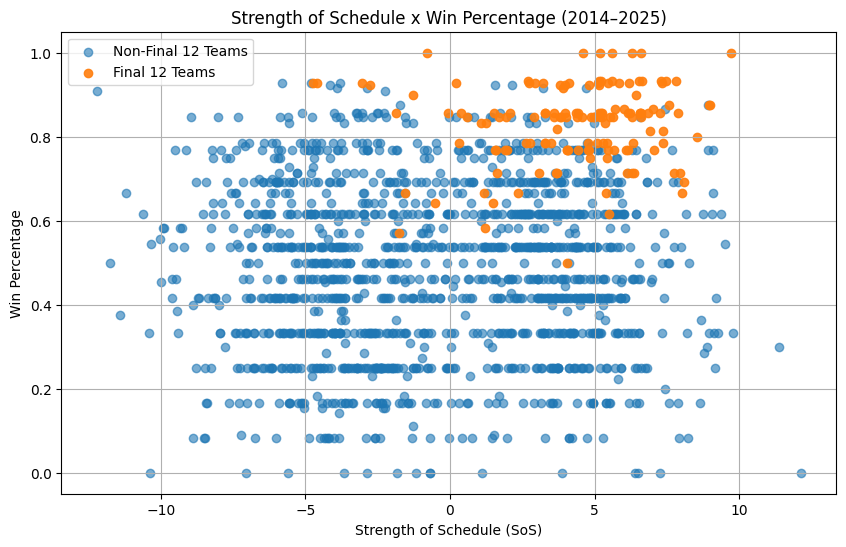

In [34]:
# Strength of Schedule vs Win Percentage Scatter Plot 
plt.figure(figsize=(10, 6))

# Non-playoff teams
plt.scatter(
    df[df['Final_12'] == 0]['SoS'],
    df[df['Final_12'] == 0]['Win_Pct'],
    alpha=0.6,
    label='Non-Final 12 Teams'
)

# Playoff teams
plt.scatter(
    df[df['Final_12'] == 1]['SoS'],
    df[df['Final_12'] == 1]['Win_Pct'],
    alpha=0.9,
    label='Final 12 Teams'
)

plt.title('Strength of Schedule x Win Percentage (2014–2025)')
plt.xlabel('Strength of Schedule (SoS)')
plt.ylabel('Win Percentage')
plt.legend()
plt.grid(True)
plt.show()



### Conference Result Relationship with Final 12 qualification

Team seasons were categorized first by conference result: Conference Champion, Runner-Up, or Other. Second, by whether or not their conference is a Power Conference (ACC, Big Ten, Big 12, Pac-12, SEC) or Non-Power Conference (American, C-USA, MAC, Mountain West, Sun Belt). Finally, by whether or not they qualified for the New Years Six bowls (or 12-team CFP). 

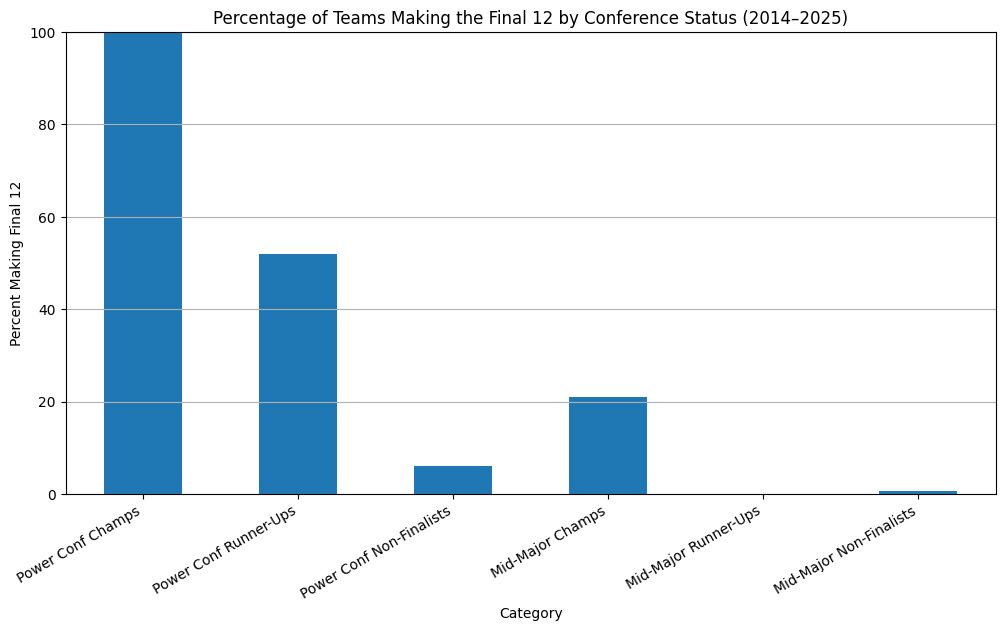

In [38]:
df_cat = df.copy()

df_cat['Category'] = np.select(
    [
        (df_cat['Power_Conf'] == 1) & (df_cat['Conf_Champ'] == 1),
        (df_cat['Power_Conf'] == 1) & (df_cat['Conf_Finalist'] == 1) & (df_cat['Conf_Champ'] == 0),
        (df_cat['Power_Conf'] == 1) & (df_cat['Conf_Finalist'] == 0),
        (df_cat['Power_Conf'] == 0) & (df_cat['Conf_Champ'] == 1),
        (df_cat['Power_Conf'] == 0) & (df_cat['Conf_Finalist'] == 1) & (df_cat['Conf_Champ'] == 0),
        (df_cat['Power_Conf'] == 0) & (df_cat['Conf_Finalist'] == 0),
    ],
    [
        'Power Conf Champs',
        'Power Conf Runner-Ups',
        'Power Conf Non-Finalists',
        'Mid-Major Champs',
        'Mid-Major Runner-Ups',
        'Mid-Major Non-Finalists'
    ],
    default='Unknown'
)

# ------------------------------------------------------------------
# Calculate percentage of teams making the Final 12
# (Final_12 is binary → mean = percentage)
# ------------------------------------------------------------------
percent_final12 = (
    df_cat.groupby('Category')['Final_12']
    .mean()
    .mul(100)
    .reindex([
        'Power Conf Champs',
        'Power Conf Runner-Ups',
        'Power Conf Non-Finalists',
        'Mid-Major Champs',
        'Mid-Major Runner-Ups',
        'Mid-Major Non-Finalists'
    ])
)

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
plt.figure(figsize=(12, 6))
percent_final12.plot(kind='bar')
plt.title('Percentage of Teams Making the Final 12 by Conference Status (2014–2025)')
plt.xlabel('Category')
plt.ylabel('Percent Making Final 12')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()


- If you win a power conference, you're in.
- If you lose a power conference championship, your odds are 50/50
- If you win a mid-major conference, your odds are just a above 20 percent
    - *This makes sense because 1 of the 5 mid-major champions is selected. With the exception of 2025 when 2 were*

## Model Building

I chose to use RandomForest and XGBoost to predict playoff qualification. The dataset was split into training and testing sets, with hyperparameter tuning performed using cross-validation. I wanted to compare the performance of both models to see which one provided better accuracy and generalization. 

In [54]:
def prediction(df, yr, target, model_name, head=12, max=15):
    """
    Train a model on historical data and predict playoff teams for a given year.
    
    Parameters:
    - df: Full dataset with all years
    - yr: Year to predict (will use all prior years as training data)
    - target: Target variable ('Final_4', 'Final_12', etc.)
    - model_name: 'RandomForest' or 'XGBoost'
    - head: Number of top predictions to consider
    - max: Maximum number of predictions to show
    
    Returns:
    - DataFrame with Team and Probability columns, sorted by probability
    """
    # Separate year data as holdout set
    df_train = df[df['Year'] < yr].copy()
    df_pred_year = df[df['Year'] == yr].copy()

    # Split features and target from training data
    X = df_train[['Wins', 'Losses', 'SoS', 'Power_Conf', 'Ranked', 
                'Conf_Champ', 'Conf_Finalist', 'Win_Pct']].values
    
    y = df_train[target]
    
     # Split into training and testing sets (using historical data only)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.10,
        random_state=0,
        stratify=y  # Maintain class balance in split
    )

    # Initialize model based on selection
    if (model_name == 'RandomForest'): 
        model = RandomForestClassifier(
            n_estimators=400, 
            n_jobs=-1,
            random_state=42,
            criterion='gini',
            class_weight='balanced' 
        ) 
    elif (model_name == 'XGBoost'):
        # Calculate class weight for imbalanced data
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        
        model = xgb.XGBClassifier(
            n_estimators=400,
            learning_rate=0.1,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            objective='binary:logistic',
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
    else:
        print(f"Model '{model_name}' not found")

    # Train the model
    model.fit(X_train, y_train)

    # Prepare prediction year data
    X_pred_year = df_pred_year[['Wins', 'Losses', 'SoS', 'Power_Conf', 'Ranked', 
                            'Conf_Champ', 'Conf_Finalist', 'Win_Pct']].values

    # Make predictions for target year
    y_pred_year = model.predict(X_pred_year)
    y_pred_proba_year = model.predict_proba(X_pred_year)[:, 1]

    # Add predictions back to dataframe
    df_pred_year['Prediction'] = y_pred_year
    df_pred_year['Prediction'] = df_pred_year['Prediction'].map({0:"no", 1:"yes"})  
    df_pred_year['Probability'] = y_pred_proba_year
    
    # Return sorted predictions
    df_pred_year = df_pred_year[['Team', 'Probability']].sort_values('Probability', 
                                                                     ascending=False)

    return df_pred_year, model

In [55]:
def compare_predictions(actual_df, rf_pred_df, xgb_pred_df, n_teams=12, n_predict=None):
    """
    Compare actual playoff results with Random Forest and XGBoost predictions.
    
    Parameters:
    - actual_df: DataFrame with 'Seed'/'Rank' and 'Team' columns for actual results
    - rf_pred_df: Random Forest predictions (from prediction() function)
    - xgb_pred_df: XGBoost predictions (from prediction() function)
    - n_teams: Number of actual playoff spots (4 or 12) - used for accuracy calculation
    - n_predict: Number of predictions to show (default: same as n_teams, but can be higher like 18)
    
    Returns:
    - comparison_df: DataFrame comparing actual vs predicted
    - statistics: Dict with accuracy metrics for both models
    """
    # Default n_predict to n_teams if not specified
    if n_predict is None:
        n_predict = n_teams
    
    # Create comparison dataframe
    comp_df = pd.DataFrame()
    
    # Handle different column names for rank
    rank_col = 'Rank' if 'Rank' in actual_df.columns else 'Seed'
    comp_df['Rank'] = actual_df[rank_col]
    comp_df['Team'] = actual_df['Team']
    
    # Get RF predictions (using n_predict for display)
    comp_df['RF Pred'] = rf_pred_df['Team'].iloc[:n_predict].values
    
    # Calculate RF accuracy: difference between actual and predicted seed
    comp_df['RF acc'] = comp_df.apply(
        lambda row: actual_df[actual_df['Team'] == row['RF Pred']][rank_col].values[0] - row['Rank']
        if row['RF Pred'] in actual_df['Team'].values else None,
        axis=1
    )
    
    # Format RF accuracy with +/- signs
    comp_df['RF acc'] = comp_df['RF acc'].apply(
        lambda x: f"+{int(x)}" if x > 0 else (f"{int(x)}" if x < 0 else "0") if pd.notna(x) else "N/A"
    )
    
    # Get XGB predictions
    comp_df['XGB Pred'] = xgb_pred_df['Team'].iloc[:n_predict].values
    
    # Calculate XGB accuracy
    comp_df['XGB acc'] = comp_df.apply(
        lambda row: actual_df[actual_df['Team'] == row['XGB Pred']][rank_col].values[0] - row['Rank']
        if row['XGB Pred'] in actual_df['Team'].values else None,
        axis=1
    )
    
    # Format XGB accuracy
    comp_df['XGB acc'] = comp_df['XGB acc'].apply(
lambda x: f"+{int(x)}" if x > 0 else (f"{int(x)}" if x < 0 else "0") if pd.notna(x) else "N/A"
    )
    
    # Select final columns
    comp_df = comp_df[['Team', 'Rank', 'RF Pred', 'RF acc', 'XGB Pred', 'XGB acc']]
    
    # Calculate statistics
    # Convert accuracy back to numeric for calculations
    rf_acc_numeric = comp_df['RF acc'].apply(
        lambda x: int(x) if x not in ['N/A', None] else None
    )
    xgb_acc_numeric = comp_df['XGB acc'].apply(
        lambda x: int(x) if x not in ['N/A', None] else None
    )
    
    # RF Statistics
    rf_avg_off = rf_acc_numeric.abs().mean()
    rf_most_overrated_idx = rf_acc_numeric.idxmin()  # Most negative = ranked too high
    rf_most_overrated_team = comp_df.loc[rf_most_overrated_idx, 'RF Pred']
    rf_most_overrated_acc = abs(int(comp_df.loc[rf_most_overrated_idx, 'RF acc']))
    rf_most_underrated_idx = rf_acc_numeric.idxmax()  # Most positive = ranked too low
    rf_most_underrated_team = comp_df.loc[rf_most_underrated_idx, 'RF Pred']
    rf_most_underrated_acc = abs(int(comp_df.loc[rf_most_underrated_idx, 'RF acc']))
    
    # Count RF correct playoff teams: Of the actual top N, how many are in our predicted top N?
    rf_top_predicted = set(rf_pred_df['Team'].iloc[:n_teams].values)
    actual_top = set(actual_df['Team'].iloc[:n_teams].values)
    rf_playoff_correct = len(actual_top.intersection(rf_top_predicted))
    
    # XGB Statistics
    xgb_avg_off = xgb_acc_numeric.abs().mean()
    xgb_most_overrated_idx = xgb_acc_numeric.idxmin()
    xgb_most_overrated_team = comp_df.loc[xgb_most_overrated_idx, 'XGB Pred']
    xgb_most_overrated_acc = abs(int(comp_df.loc[xgb_most_overrated_idx, 'XGB acc']))
    xgb_most_underrated_idx = xgb_acc_numeric.idxmax()
    xgb_most_underrated_team = comp_df.loc[xgb_most_underrated_idx, 'XGB Pred']
    xgb_most_underrated_acc = abs(int(comp_df.loc[xgb_most_underrated_idx, 'XGB acc']))
    
    # Count XGB correct playoff teams
    xgb_top_predicted = set(xgb_pred_df['Team'].iloc[:n_teams].values)
    xgb_playoff_correct = len(actual_top.intersection(xgb_top_predicted))
    
    # Package statistics
    statistics = {
        'rf_avg_off': rf_avg_off,
        'rf_most_overrated': (rf_most_overrated_team, rf_most_overrated_acc),
        'rf_most_underrated': (rf_most_underrated_team, rf_most_underrated_acc),
        'rf_playoff_correct': rf_playoff_correct,
        'xgb_avg_off': xgb_avg_off,
        'xgb_most_overrated': (xgb_most_overrated_team, xgb_most_overrated_acc),
        'xgb_most_underrated': (xgb_most_underrated_team, xgb_most_underrated_acc),
        'xgb_playoff_correct': xgb_playoff_correct,
        'n_teams': n_teams,
        'rf_acc_numeric': rf_acc_numeric,
        'xgb_acc_numeric': xgb_acc_numeric
    }
    
    return comp_df, statistics


def print_statistics(stats):
    """Print formatted statistics from compare_predictions()."""
    print(f"RF Average Off-By: {stats['rf_avg_off']:.2f}")
    print(f"Most Overrated: {stats['rf_most_overrated'][0]} ({stats['rf_most_overrated'][1]} spots lower)")
    print(f"Most Underrated: {stats['rf_most_underrated'][0]} ({stats['rf_most_underrated'][1]} spots higher)")
    print(f"Playoff Teams Predicted: {stats['rf_playoff_correct']}/{stats['n_teams']}")
    
    print(f"\nXGB Average Off-By: {stats['xgb_avg_off']:.2f}")
    print(f"Most Overrated: {stats['xgb_most_overrated'][0]} ({stats['xgb_most_overrated'][1]} spots lower)")
    print(f"Most Underrated: {stats['xgb_most_underrated'][0]} ({stats['xgb_most_underrated'][1]} spots higher)")
    print(f"Playoff Teams Predicted: {stats['xgb_playoff_correct']}/{stats['n_teams']}")

## Prediction 1: 2023 College Football Playoff (Final 4)

This was the final year of the 4-team playoff format. Using the 'Final_4; target I predicted with both models. RandomForest achieved an 'Off-by' score of less than 1,it's top 6 teams predicted teams were an average of less than 1 rank away from the actual playoff teams. Notably, the controversy around Florida State being left out of the playoff was reflected in the model's predictions, as they were included in both predictions. This showcases the model's limitation-- knowing key injuries and team news. 

In [56]:
# Train models and get predictions for 2023 Final 4
rf_4_2023, rf_model_2023 = prediction(df, 2023, "Final_4", "RandomForest")
xgb_4_2023, xgb_model_2023 = prediction(df, 2023, "Final_4", "XGBoost")

# Actual 2023 playoff teams
actual_4_2023 = pd.DataFrame({
    "Seed": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Team": ["Michigan", "Washington", "Texas", "Alabama",
             "Florida State", "Georgia", "Ohio State", "Oregon", 
             "Missouri", "Penn State", "Ole Miss", "Liberty", ]
})

# Compare predictions to actual results
comp_4_2023, stats_4_2023 = compare_predictions(actual_4_2023, rf_4_2023, xgb_4_2023, n_teams=4, n_predict=12)

print("\n2023 College Football Playoff Predictions:")
print(comp_4_2023.head(4))
print("\n")
print(comp_4_2023.iloc[4:6])
print("\n")
print_statistics(stats_4_2023)


2023 College Football Playoff Predictions:
         Team  Rank        RF Pred RF acc       XGB Pred XGB acc
0    Michigan     1       Michigan      0       Michigan       0
1  Washington     2          Texas     +1          Texas      +1
2       Texas     3     Washington     -1     Washington      -1
3     Alabama     4  Florida State     +1  Florida State      +1


            Team  Rank  RF Pred RF acc    XGB Pred XGB acc
4  Florida State     5  Georgia     +1     Georgia      +1
5        Georgia     6  Alabama     -2  Ohio State      +1


RF Average Off-By: 0.91
Most Overrated: Alabama (2 spots lower)
Most Underrated: Texas (1 spots higher)
Playoff Teams Predicted: 3/4

XGB Average Off-By: 1.50
Most Overrated: Alabama (3 spots lower)
Most Underrated: Liberty (4 spots higher)
Playoff Teams Predicted: 3/4


### Feature Importance - 2023 Final 4 Models

Both models have the same top 3 features: win percentage, losses, and ranked status. However, XGBoost places more importance on ranked status. I was surprised to see that strength of schedule was not a more important feature, as it is often discussed in playoff selection debates.

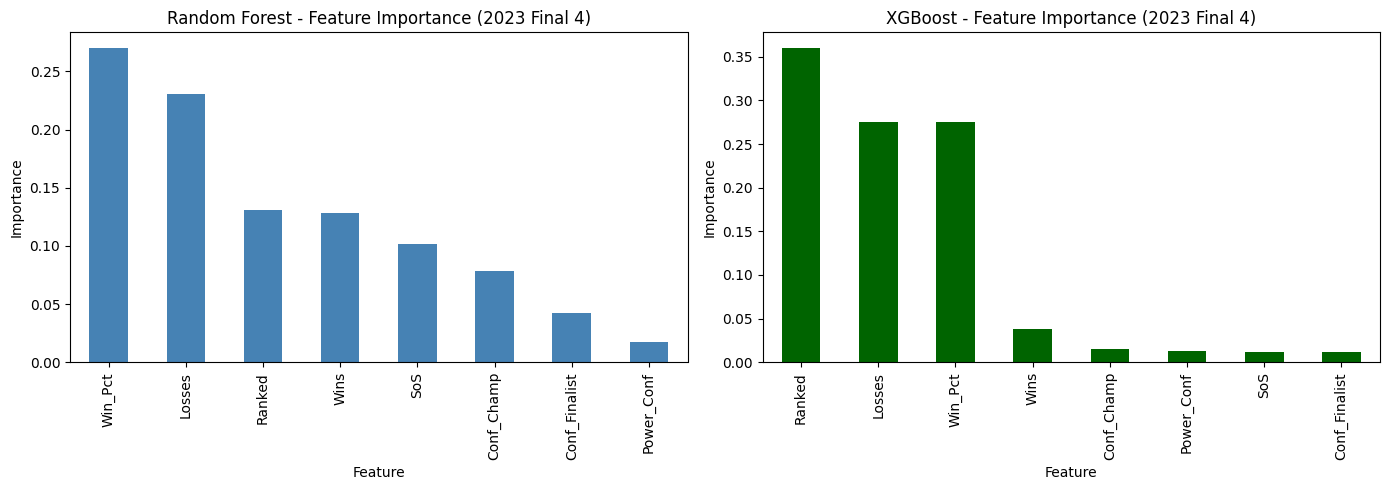

In [57]:
# Feature names
feature_names = ['Wins', 'Losses', 'SoS', 'Power_Conf', 'Ranked', 'Conf_Champ', 'Conf_Finalist', 'Win_Pct']

# Random Forest feature importance
rf_importance_2023 = pd.Series(rf_model_2023.feature_importances_, 
                                index=feature_names).sort_values(ascending=False)

# XGBoost feature importance
xgb_importance_2023 = pd.Series(xgb_model_2023.feature_importances_, 
                                 index=feature_names).sort_values(ascending=False)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

rf_importance_2023.plot.bar(ax=ax1, color='steelblue')
ax1.set_title('Random Forest - Feature Importance (2023 Final 4)')
ax1.set_ylabel('Importance')
ax1.set_xlabel('Feature')

xgb_importance_2023.plot.bar(ax=ax2, color='darkgreen')
ax2.set_title('XGBoost - Feature Importance (2023 Final 4)')
ax2.set_ylabel('Importance')
ax2.set_xlabel('Feature')

plt.tight_layout()
plt.show()

## Prediction 2: 2024 College Football Playoff (Final 12)

First year of the new 12-team playoff format. Using the 'New_Years_Six' target I predicted with both models (typically top 11 teams + top mid-major conference champion). RandomForest performed better, predicted 10 of the 12 teams correctly. It incorrectly included Miami (FL), which was a bubble team, and left out Boise State, the mid-major. XGBoost perfromed worse but had 2 playoff teams ranked as 13 and 14. Both models highly viewed the Big-12 conference, as evidenced by both model's prediction of Arizona State and Iowa State.

In [58]:
# Train models and get predictions for 2024 Final 12
rf_12_2024, rf_model_2024 = prediction(df, 2024, "Final_12", "RandomForest")
xgb_12_2024, xgb_model_2024 = prediction(df, 2024, "Final_12", "XGBoost")

# Actual 2024 playoff teams (first 12-team playoff)
actual_12_2024 = pd.DataFrame({
    "Rank": list(range(1, 19)),
    "Team": [
        "Oregon", "Georgia", "Texas", "Penn State", 
        "Notre Dame", "Ohio State", "Tennessee", "Indiana",
        "Boise State", "SMU", "Arizona State", "Clemson",
        
        "Alabama", "Miami (FL)", "Ole Miss",
        "South Carolina", "BYU", "Iowa State",
    ]
})

# Compare predictions to actual results
comp_12_2024, stats_12_2024 = compare_predictions(actual_12_2024, rf_12_2024, xgb_12_2024, n_teams=12, n_predict=18)

print("\n2024 College Football Playoff Predictions:")
print(comp_12_2024.head(12))
print("\n")
print(comp_12_2024.iloc[12:])
print("\n")
print_statistics(stats_12_2024)


2024 College Football Playoff Predictions:
             Team  Rank        RF Pred RF acc       XGB Pred XGB acc
0          Oregon     1         Oregon      0         Oregon       0
1         Georgia     2        Georgia      0  Arizona State      +9
2           Texas     3     Penn State     +1     Penn State      +1
3      Penn State     4  Arizona State     +7        Georgia      -2
4      Notre Dame     5        Clemson     +7     Miami (FL)      +9
5      Ohio State     6          Texas     -3        Clemson      +6
6       Tennessee     7     Miami (FL)     +7          Texas      -4
7         Indiana     8      Tennessee     -1     Ohio State      -2
8     Boise State     9     Iowa State     +9      Tennessee      -2
9             SMU    10            SMU      0     Iowa State      +8
10  Arizona State    11     Notre Dame     -6            SMU      -1
11        Clemson    12     Ohio State     -6       Colorado     N/A


              Team  Rank           RF Pred RF acc     XGB

### Feature Importance - 2024 Final 12 Models

Both models had ranked status as its most important feature, however XGBoost shifted to placing nearly all importance on ranked status. This makes sense with a 12 team predictor, as ranked status (top 25) is an almost certain indication of playoff inclusion.

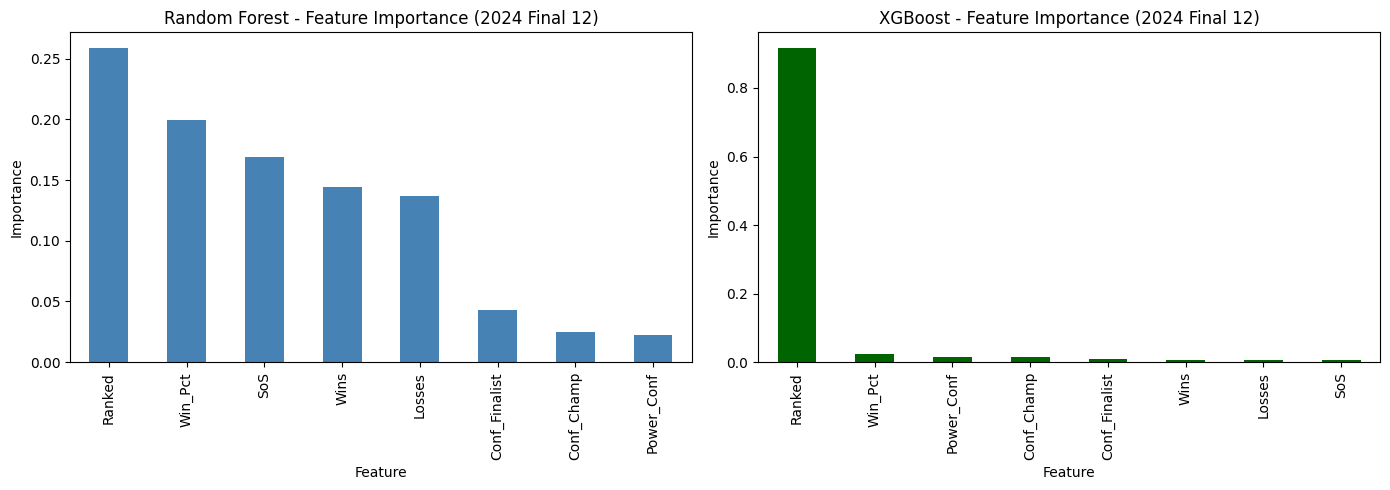

In [59]:
# Random Forest feature importance
rf_importance_2024 = pd.Series(rf_model_2024.feature_importances_, 
                                index=feature_names).sort_values(ascending=False)

# XGBoost feature importance
xgb_importance_2024 = pd.Series(xgb_model_2024.feature_importances_, 
                                 index=feature_names).sort_values(ascending=False)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

rf_importance_2024.plot.bar(ax=ax1, color='steelblue')
ax1.set_title('Random Forest - Feature Importance (2024 Final 12)')
ax1.set_ylabel('Importance')
ax1.set_xlabel('Feature')

xgb_importance_2024.plot.bar(ax=ax2, color='darkgreen')
ax2.set_title('XGBoost - Feature Importance (2024 Final 12)')
ax2.set_ylabel('Importance')
ax2.set_xlabel('Feature')

plt.tight_layout()
plt.show()

## Prediction 3: 2025 College Football Playoff (Final 12)

For the final part of the project, I predicted the 2025 College Football Playoff using both models. This year was unique because it included not 1 but 2 mid-major schools, which I knew my models would ot be prepared for. RandomForest recorded its best score, boasting an 'Off-by' score of less than 3. It also had James Madison, the 2nd mid-major playoff team, one spot away from inclusion. This year's controversy surrounded the inclusion of only 2 teams of Alabama, Miami (Fl), Notre Dame,  and BYU. Both models strongly disagree with the comitees decision to leave out BYU. It also predicted Notre Dame to be included, which shows a model limitation. Head-to-head was the reason they were left out, which the model does not account for.

In [60]:
# Train models and get predictions for 2025 Final 12
rf_12_2025, rf_model_2025 = prediction(df, 2025, "Final_12", "RandomForest")
xgb_12_2025, xgb_model_2025 = prediction(df, 2025, "Final_12", "XGBoost")

# Actual 2025 playoff teams
actual_12_2025 = pd.DataFrame({
    "Rank": list(range(1, 19)),
    "Team": [
        "Indiana", "Ohio State", "Georgia", "Texas Tech",
        "Oregon", "Ole Miss", "Texas A&M", "Oklahoma",
        "Alabama", "Miami (FL)", "Tulane", "James Madison",
        
        "Notre Dame", "BYU", "Texas", "Vanderbilt", "Utah", "USC"
    ]
})

# Compare predictions to actual results
comp_12_2025, stats_12_2025 = compare_predictions(actual_12_2025, rf_12_2025, xgb_12_2025, n_teams=12, n_predict=18)

print("\n2025 College Football Playoff Predictions:")
print(comp_12_2025.head(12))  # Show top 6
print('\n')  
print(comp_12_2025.iloc[12:])  # Show teams outside it

print("\n")
print_statistics(stats_12_2025)


2025 College Football Playoff Predictions:
             Team  Rank     RF Pred RF acc       XGB Pred XGB acc
0         Indiana     1     Georgia     +2        Georgia      +2
1      Ohio State     2         BYU    +12         Oregon      +3
2         Georgia     3  Ohio State     -1     Miami (FL)      +7
3      Texas Tech     4     Indiana     -3     Ohio State      -2
4          Oregon     5      Oregon      0            BYU      +9
5        Ole Miss     6   Texas A&M     +1       Oklahoma      +2
6       Texas A&M     7  Miami (FL)     +3     Notre Dame      +6
7        Oklahoma     8    Oklahoma      0        Indiana      -7
8         Alabama     9  Texas Tech     -5        Alabama       0
9      Miami (FL)    10  Notre Dame     +3      Texas A&M      -3
10         Tulane    11      Tulane      0         Tulane       0
11  James Madison    12    Ole Miss     -6  Arizona State     N/A


          Team  Rank        RF Pred RF acc    XGB Pred XGB acc
12  Notre Dame    13  James Madis

### Decision Tree Visualization — 2025 Final 12 Models

This sample tree represents the thought process of one decision tree (one voter) inside the Random Forest. Here are some insights:

---

## Likely ways to get IN

1. Conference finalist → ranked → win 80% of games → conference champion → **IN**

2. Conference finalist → ranked → win 80% of games → decent strength of schedule → **IN**

3. Conference finalist → unranked → power conference → conference champion → **IN** (even though weak, still a power conference champ)

4. Not conference finalist → ranked → win 78% of games → solid strength of schedule → **IN (bubble)** (SEC or B10 team just missed out on conference championship)

---

## Likely ways to be OUT

1. Not conference finalist → unranked → **OUT**

2. Conference finalist → extremely weak strength of schedule → **OUT** (mid-major that played no-one)

3. Ranked → win 68% of games → **OUT** (likely ranked 20-25)

4. Not conference finalist → ranked → losses > 4 → weak strength of schedule → **OUT**


In [61]:
from sklearn.tree import export_text

# Feature names for tree visualization
feature_names = ['Wins', 'Losses', 'SoS', 'Power_Conf', 'Ranked', 'Conf_Champ', 'Conf_Finalist', 'Win_Pct']

# Export Random Forest tree as text (first tree, limited depth)
print("Random Forest - Sample Decision Tree Rules (2025 Final 12):")
tree_rules_rf = export_text(rf_model_2025.estimators_[0],  # First tree
                             feature_names=feature_names,
                             max_depth=4)  # Limit depth for readability
print(tree_rules_rf)

Random Forest - Sample Decision Tree Rules (2025 Final 12):
|--- Conf_Finalist <= 0.50
|   |--- Ranked <= 0.50
|   |   |--- Losses <= 1.50
|   |   |   |--- class: 0.0
|   |   |--- Losses >  1.50
|   |   |   |--- class: 0.0
|   |--- Ranked >  0.50
|   |   |--- Win_Pct <= 0.76
|   |   |   |--- Losses <= 4.50
|   |   |   |   |--- Losses <= 3.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Losses >  3.50
|   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- Losses >  4.50
|   |   |   |   |--- SoS <= 6.84
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- SoS >  6.84
|   |   |   |   |   |--- class: 0.0
|   |   |--- Win_Pct >  0.76
|   |   |   |--- SoS <= 0.31
|   |   |   |   |--- class: 0.0
|   |   |   |--- SoS >  0.31
|   |   |   |   |--- Win_Pct <= 0.78
|   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |--- Win_Pct >  0.78
|   |   |   |   |   |--- truncated branch of depth 7
|--- Conf_Finalist >  0.50
|   |--- SoS <= -4.77
|   |   |---

## Model Performance Comparison

With a small sample size, it is clear to see that RandomForest outperformed XGBoost in predicting College Football Playoff teams, based on 'Off-by' score and number of correct teams predicted.

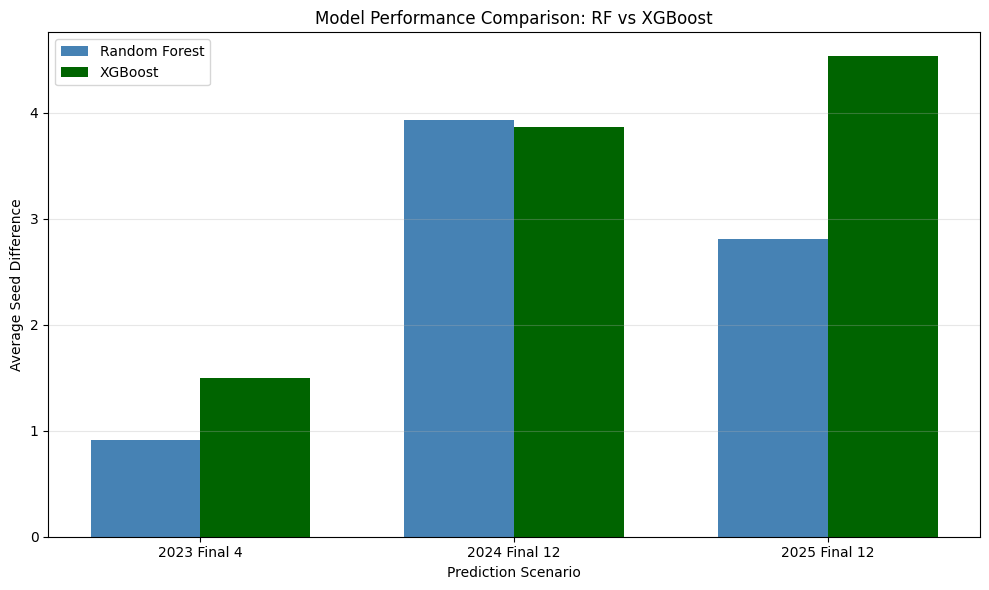

In [62]:
# Compare RF vs XGBoost average error across all predictions
comparison_data = {
    'Prediction': ['2023 Final 4', '2024 Final 12', '2025 Final 12'],
    'RF Avg Off': [
        stats_4_2023['rf_avg_off'],
        stats_12_2024['rf_avg_off'],
        stats_12_2025['rf_avg_off']
    ],
    'XGB Avg Off': [
        stats_4_2023['xgb_avg_off'],
        stats_12_2024['xgb_avg_off'],
        stats_12_2025['xgb_avg_off']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(comparison_df))
width = 0.35

ax.bar([i - width/2 for i in x], comparison_df['RF Avg Off'], 
       width, label='Random Forest', color='steelblue')
ax.bar([i + width/2 for i in x], comparison_df['XGB Avg Off'], 
       width, label='XGBoost', color='darkgreen')

ax.set_xlabel('Prediction Scenario')
ax.set_ylabel('Average Seed Difference')
ax.set_title('Model Performance Comparison: RF vs XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Prediction'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Limitations and Future Work

The models were most definitely limited by the lack of data points, with only 10 years of playoff data available. Additionally, the models do not account for key factors such as injuries, coaching changes, and head-to-head results, which can significantly impact playoff selections. Additionally, the models ranked teams based on probability of inclusion, this is similar but difference than actually ranking teams. Future work could involve different models and more features.